# Bragg grating

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil
from IPython import display

import meep as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../../lib')
from ataitmeep import *
import ataitbragg
from ataitbragg import bragg_cell, bragg_geometry, livefield

In [3]:
from lightlab.util import io
from lightlab.util.data import Spectrum, FunctionBundle, MeasuredFunction

In [4]:
io.dataHome /= 'reflectors'

In [5]:
# Define the system
# parameters for 1220nm
sm_width = .35
thick = 1e20
# ataitbragg.default_geometry = dict(
#                         sm_width = sm_width,  # um
#                         pitch = .28,
#                         duty = .5,
# #                         width_2 = .35,
#                         dw = .1,
#                         n_periods = 10,
#                         buffer = 5,  # um
#                         thickness = thick,
#                        )

ataitbragg.resolution = 20

-----------
Initializing structure...
run 0 finished at t = 0.0 (0 timesteps)


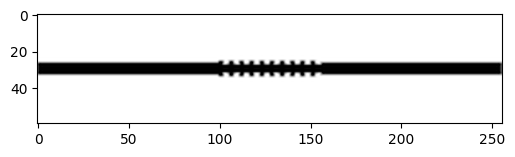

In [7]:
# Do the simulation, and verify the geometry
sim = mp.Simulation(
#                     progress_interval=1e6,
                    **ataitbragg.sim_kwargs())

eps_data = show_geometry(sim)

run 1 finished at t = 160.0 (6400 timesteps)


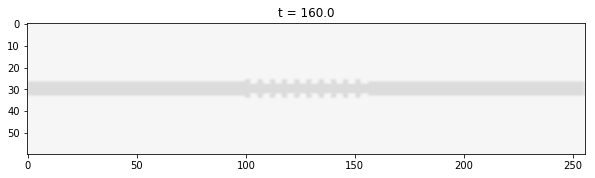

In [8]:
def plot_sim(until=200):
    sim.reset_meep()
    shutil.rmtree('outputs', ignore_errors=True)
    sim.use_output_directory('outputs')
    sim.run(
            mp.at_beginning(livefield),
            mp.at_every(5, livefield),
#             mp.at_every(1, mp.output_png(mp.Ey, "-Zc dkbluered")),
#             mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
            until=until)
    # now make the gif
#     subprocess.check_call(['convert', 'outputs/ey-*.png', 'ey.gif'])
#     subprocess.check_call(['open', '-a', 'Safari', 'ey.gif'])

plt.figure(figsize=(10,6))
plot_sim(160)

field decay(t = 120.10000000000001): 7.193850479946021e-10 / 0.028138480030375532 = 2.5565881569225663e-08
run 0 finished at t = 120.10000000000001 (4804 timesteps)


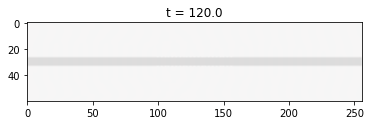

In [9]:
# Ok first do the straight waveguide
def do_baseline(do_live=True, geo=None, **kwargs):
    kwargs['dw'] = 0
    sim, refl, tran = ataitbragg.do_simrun(base_refl_data=None, do_live=True, geo=None, **kwargs)
    
    # for normalization run, save flux fields data for reflection plane
    straight_refl_data = sim.get_flux_data(refl)
    # This one is to normalize power. the other was to negate forward-propagating wave
    straight_tran_flux = np.array(mp.get_fluxes(tran))
    return straight_refl_data, straight_tran_flux

straight_refl_data, straight_tran_flux = do_baseline()  # comment this when you dont need to do it again

field decay(t = 120.10000000000001): 1.1882359359042583e-08 / 0.020786280734922367 = 5.716443220686137e-07
run 0 finished at t = 120.10000000000001 (4804 timesteps)


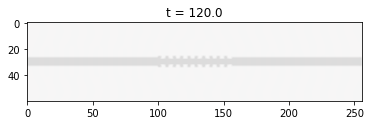

In [10]:
def do_trial(base_refl_data, do_live=True, geo=None, **kwargs):
    _, refl, tran = ataitbragg.do_simrun(base_refl_data=base_refl_data, do_live=do_live, geo=geo, **kwargs)

    bend_refl_flux = np.array(mp.get_fluxes(refl))
    flux_freqs = np.array(mp.get_flux_freqs(refl))
    return bend_refl_flux, flux_freqs

bend_refl_flux, flux_freqs = do_trial(straight_refl_data, do_live=True)

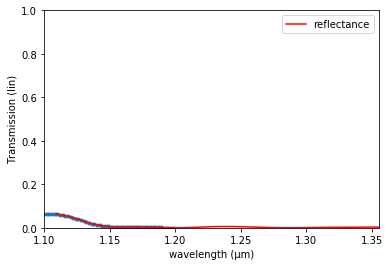

In [11]:
wl = 1 / flux_freqs
Rs = -bend_refl_flux/np.array(straight_tran_flux)
spct = Spectrum(wl[::-1], Rs[::-1], inDbm=False)
spct.crop([1.1,1.2]).simplePlot('.')
plt.plot(wl,Rs,'r-',label='reflectance')
# plt.plot(wl,1-Rs,'go-',label='loss')
# plt.axis([1.0, 1.44, 0, 1])
plt.ylim([0,1])
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")


In [16]:
# parameter sweep
isResimulating = False
isSaving = True
filename = 'bragg-periods.pkl'

# n_period_vals = [10, 20, 30]
pname, pvals = 'dw', [.05, .1, .15, .2]
# pitch_vals = [.26, .27, .28]

if isResimulating:
    spectra = FunctionBundle()
    for p in pvals:
        geo_kwarg = {pname: p}
        bend_refl_flux, flux_freqs = do_trial(straight_refl_data, do_live=False, **geo_kwarg)
        Rs = -bend_refl_flux/straight_tran_flux
        spct1 = Spectrum(wl[::-1], Rs[::-1], inDbm=False)
        spectra.addDim(spct1.db())
    if isSaving:
        io.savePickleGzip(dataTuple=(pname, pvals, spectra), filename=filename)
else:
    pname, pvals, spectra = io.loadPickleGzip(filename=filename)
   

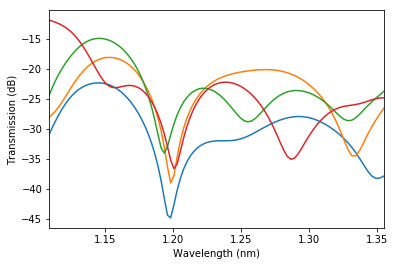

In [17]:
spectra.simplePlot()
# sp = spectra[0]
# sp.lin().simplePlot()
# spct.db().simplePlot()